<a href="https://colab.research.google.com/github/17004963/SP1-LABS/blob/master/lesson3_text_classifier_multilabel_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os, re, json, functools

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

TensorFlow 2.x selected.


In [2]:
pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)
     |████████████████████████████████| 122kB 8.0MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.25.7
    Uninstalling urllib3-1.25.7:
      Successfully uninstalled urllib3-1.25.7


#Dataset

In [0]:
os.environ['KAGGLE_USERNAME'] = "alejandrocolindres"
os.environ['KAGGLE_KEY'] = "17e1729763c87121d962b24e9fb6a6c3"

In [4]:
#https://www.kaggle.com/rounakbanik/the-movies-dataset
!kaggle datasets download tmdb/tmdb-movie-metadata


 56% 5.00M/8.89M [00:00<00:00, 15.7MB/s]
100% 8.89M/8.89M [00:00<00:00, 25.6MB/s]


In [5]:
!unzip -o 'tmdb-movie-metadata.zip'

Archive:  tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


In [6]:
os.listdir()

['.config',
 'tmdb_5000_credits.csv',
 'tmdb-movie-metadata.zip',
 'tmdb_5000_movies.csv',
 'sample_data']

In [7]:
movies = pd.read_csv('tmdb_5000_movies.csv')
movies.head

<bound method NDFrame.head of          budget  ... vote_count
0     237000000  ...      11800
1     300000000  ...       4500
2     245000000  ...       4466
3     250000000  ...       9106
4     260000000  ...       2124
...         ...  ...        ...
4798     220000  ...        238
4799       9000  ...          5
4800          0  ...          6
4801          0  ...          7
4802          0  ...         16

[4803 rows x 20 columns]>

In [8]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [9]:
movies.genres

0       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
1       [{"id": 12, "name": "Adventure"}, {"id": 14, "...
2       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
3       [{"id": 28, "name": "Action"}, {"id": 80, "nam...
4       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
                              ...                        
4798    [{"id": 28, "name": "Action"}, {"id": 80, "nam...
4799    [{"id": 35, "name": "Comedy"}, {"id": 10749, "...
4800    [{"id": 35, "name": "Comedy"}, {"id": 18, "nam...
4801                                                   []
4802                  [{"id": 99, "name": "Documentary"}]
Name: genres, Length: 4803, dtype: object

In [10]:
movies.overview

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4798    El Mariachi just wants to play his guitar and ...
4799    A newlywed couple's honeymoon is upended by th...
4800    "Signed, Sealed, Delivered" introduces a dedic...
4801    When ambitious New York attorney Sam is sent t...
4802    Ever since the second grade when he first saw ...
Name: overview, Length: 4803, dtype: object

In [12]:
movies = movies[movies['id'] != '0']
movies = movies[movies['genres'] != "[]"]
movies = movies[~pd.isna(movies['overview'])]

overview = movies['overview']
genres = movies['genres']

dataset = movies[['overview', 'genres']] 

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [14]:
len(dataset)

4772

In [15]:
#DATASET_SIZE = len(genres)
#CLASS_NAMES = ['Drama','Comedy','Thriller','Romance','Action','Horror','Crime','Documentary','Adventure','Science Fiction']
CLASS_NAMES = ['Drama','Comedy','Thriller','Romance','Action']
CLASS_COUNT = len(CLASS_NAMES)
CLASS_COUNT

5

In [16]:
dataset.iloc[0]['genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [17]:
dataset['genres'].replace("\'", "\"", regex=True, inplace=True)
dataset.iloc[0]['genres']

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [0]:
#genre_to_id = dict()
label_count = dict()

def genre_to_list(str_genre):
  keep = True
  genre_list = list(map(lambda genre:genre['name'],json.loads(str_genre)))
  
  for genre in genre_list:
    count = label_count.get(genre, 0) + 1
    label_count[genre] = count
    if (count > 5000):
      keep = False
    #if (genre_to_id.get(genre,-1) == -1):
    #  genre_to_id[genre] = len(genre_to_id.keys())
  genres_as_ids = list(map(lambda x: CLASS_NAMES.index(x), filter(lambda x: x in CLASS_NAMES, genre_list)))
  #genres_as_ids = list(map(lambda x:genre_to_id[x], genre_list)) 
  genres_one_hot = list()

  if (len(genres_as_ids) > 0 and keep):
    genres_one_hot = tf.keras.utils.to_categorical(genres_as_ids, CLASS_COUNT, dtype='int')
    genres_one_hot = functools.reduce(lambda x,y : x+y,genres_one_hot)

  return genres_one_hot

In [19]:
dataset['genres'] = dataset['genres'].apply(lambda x: genre_to_list(x))
dataset.iloc[0]['genres']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([0, 0, 0, 0, 1])

In [20]:
dataset = dataset[~dataset['genres'].str.len().eq(0)]
len(dataset)

4351

In [21]:
sorted(label_count.items(), key=lambda x: x[1], reverse=True)

[('Drama', 2296),
 ('Comedy', 1722),
 ('Thriller', 1274),
 ('Action', 1154),
 ('Romance', 894),
 ('Adventure', 790),
 ('Crime', 696),
 ('Science Fiction', 535),
 ('Horror', 519),
 ('Family', 513),
 ('Fantasy', 424),
 ('Mystery', 348),
 ('Animation', 234),
 ('History', 197),
 ('Music', 185),
 ('War', 144),
 ('Documentary', 108),
 ('Western', 82),
 ('Foreign', 34),
 ('TV Movie', 8)]

In [0]:
#CLASS_NAMES = list(genre_to_id.keys())
#CLASS_COUNT == len(CLASS_NAMES), CLASS_NAMES

##Split dataset

In [23]:
train_split = dataset.sample(frac = 0.7,random_state=42)
test_split = dataset.drop(train_split.index).sample(frac = 0.5)
validation_split = dataset.drop(train_split.index).drop(test_split.index)

train_split.shape, validation_split.shape, test_split.shape

((3046, 2), (653, 2), (652, 2))

In [24]:
train_split.iloc[0]

overview    The story of the first major battle of the Ame...
genres                                        [0, 0, 0, 0, 1]
Name: 579, dtype: object

In [25]:
train_labels = train_split['genres']
test_labels = test_split['genres']
validation_labels = validation_split['genres']
train_labels.shape, test_labels.shape, validation_labels.shape

((3046,), (652,), (653,))

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_split['overview'], train_split['genres']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_split['overview'], test_split['genres']))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_split['overview'], validation_split['genres']))
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.int32, name=None))

In [27]:
overview, genres = next(iter(train_dataset))
overview, genres

(<tf.Tensor: shape=(), dtype=string, numpy=b'The story of the first major battle of the American phase of the Vietnam War and the soldiers on both sides that fought it.'>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 1], dtype=int32)>)

In [0]:
batch_size = 128
shuffle_buffer_size = 1000

In [0]:
train_dataset = train_dataset.shuffle(shuffle_buffer_size).repeat().batch(batch_size)
validation_dataset = validation_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size)

In [30]:
overview, genres = next(iter(train_dataset))
overview.shape, genres.shape

(TensorShape([128]), TensorShape([128, 5]))

#Model

In [0]:
epochs = 20
train_steps = 10
validation_steps = 5

## Estimator

In [0]:
description_embeddings = hub.text_embedding_column(
    "overview", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1",
    trainable=False
)

In [33]:
estimator = tf.estimator.DNNEstimator(
    head=tf.estimator.MultiLabelHead(CLASS_COUNT, loss_reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE),
    hidden_units=[64,16],
    feature_columns=[description_embeddings]
)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmps8y7uatq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmps8y7uatq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
def input_fn(features, labels=None, training=True, batch_size=batch_size):
  inputs = {
    "overview": np.array(features)
  }

  if labels is not None:
    inputs = (inputs, np.array(labels.tolist()))  
  
  dataset = tf.data.Dataset.from_tensor_slices(inputs)

  if training:
      dataset = dataset.shuffle(shuffle_buffer_size).repeat()
  
  return dataset.batch(batch_size)

In [35]:
estimator.train(
    input_fn=lambda: input_fn(train_split['overview'], train_split['genres'], batch_size=32),
    steps=epochs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmps8y7uatq/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmps8y7uatq/model.ckpt.


INFO:tensorflow:loss = 0.72029483, step = 0


INFO:tensorflow:loss = 0.72029483, step = 0


INFO:tensorflow:Saving checkpoints for 20 into /tmp/tmps8y7uatq/model.ckpt.


INFO:tensorflow:Saving checkpoints for 20 into /tmp/tmps8y7uatq/model.ckpt.


INFO:tensorflow:Loss for final step: 0.70479524.


INFO:tensorflow:Loss for final step: 0.70479524.


In [36]:
metrics = estimator.evaluate(
    input_fn=lambda: input_fn(test_split['overview'], test_split['genres'], training=False))
metrics

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-03T02:03:27Z


INFO:tensorflow:Starting evaluation at 2020-02-03T02:03:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmps8y7uatq/model.ckpt-20


INFO:tensorflow:Restoring parameters from /tmp/tmps8y7uatq/model.ckpt-20


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.96227s


INFO:tensorflow:Inference Time : 1.96227s


INFO:tensorflow:Finished evaluation at 2020-02-03-02:03:29


INFO:tensorflow:Finished evaluation at 2020-02-03-02:03:29


INFO:tensorflow:Saving dict for global step 20: auc = 0.3967083, auc_precision_recall = 0.288829, average_loss = 0.7091354, global_step = 20, loss = 0.70688206


INFO:tensorflow:Saving dict for global step 20: auc = 0.3967083, auc_precision_recall = 0.288829, average_loss = 0.7091354, global_step = 20, loss = 0.70688206


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 20: /tmp/tmps8y7uatq/model.ckpt-20


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 20: /tmp/tmps8y7uatq/model.ckpt-20


{'auc': 0.3967083,
 'auc_precision_recall': 0.288829,
 'average_loss': 0.7091354,
 'global_step': 20,
 'loss': 0.70688206}

In [0]:
test_input = "The Imperial Forces -- under orders from cruel Darth Vader (David Prowse) -- hold Princess Leia (Carrie Fisher) hostage, in their efforts to quell the rebellion against the Galactic Empire. Luke Skywalker (Mark Hamill) and Han Solo (Harrison Ford), captain of the Millennium Falcon, work together with the companionable droid duo R2-D2 (Kenny Baker) and C-3PO (Anthony Daniels) to rescue the beautiful princess, help the Rebel Alliance, and restore freedom and justice to the Galaxy."
predictions = estimator.predict(
    input_fn=lambda: input_fn([test_input], training=False, batch_size=1)
)

In [38]:
predicted_labels = ""
for prediction in predictions:  
  for i in prediction['probabilities'].argsort()[-3:][::-1]:
    predicted_labels += CLASS_NAMES[i] + " (" + str(np.around(prediction['probabilities'][i], decimals=3)) + ")\n"
    
print(predicted_labels)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmps8y7uatq/model.ckpt-20


INFO:tensorflow:Restoring parameters from /tmp/tmps8y7uatq/model.ckpt-20


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Action (0.549)
Thriller (0.496)
Comedy (0.481)




##Keras Layer


In [0]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                           output_shape=[128], input_shape=[], dtype=tf.string)

In [40]:
model = Sequential([
    hub_layer,
    Dense(128, activation='relu'),  
    Dense(CLASS_COUNT, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 124,659,845
Trainable params: 17,157
Non-trainable params: 124,642,688
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=train_steps,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps
                   )         

Train for 10 steps, validate for 5 steps
Epoch 1/20
10/10 [==============================] - 3s 284ms/step - loss: 0.6799 - accuracy: 0.5827 - val_loss: 0.6565 - val_accuracy: 0.6697
Epoch 2/20
10/10 [==============================] - 3s 252ms/step - loss: 0.6414 - accuracy: 0.6823 - val_loss: 0.6237 - val_accuracy: 0.6781
Epoch 3/20
10/10 [==============================] - 3s 255ms/step - loss: 0.6124 - accuracy: 0.6856 - val_loss: 0.6024 - val_accuracy: 0.6847
Epoch 4/20
10/10 [==============================] - 3s 253ms/step - loss: 0.5910 - accuracy: 0.6992 - val_loss: 0.5915 - val_accuracy: 0.6956
Epoch 5/20
10/10 [==============================] - 3s 253ms/step - loss: 0.5876 - accuracy: 0.6967 - val_loss: 0.5832 - val_accuracy: 0.6938
Epoch 6/20
10/10 [==============================] - 3s 250ms/step - loss: 0.5682 - accuracy: 0.7131 - val_loss: 0.5735 - val_accuracy: 0.6969
Epoch 7/20
10/10 [==============================] - 3s 251ms/step - loss: 0.5740 - accuracy: 0.6988 - val_l

###Validation

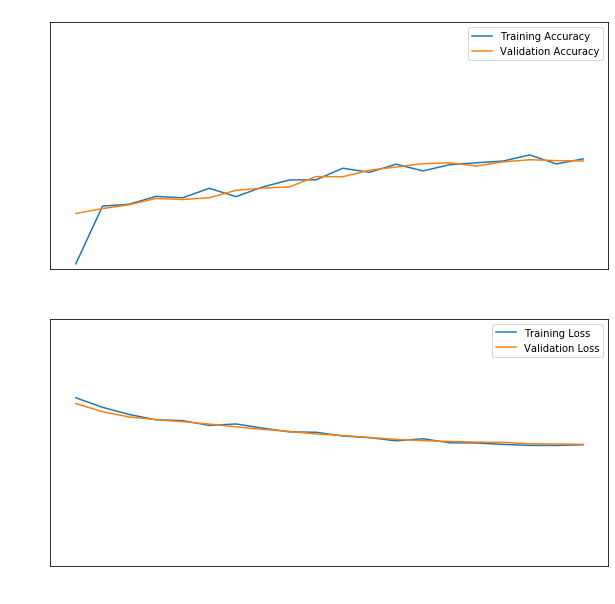

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Cross Entropy')
plt.ylim([0.0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=3)

print('Loss:', test_loss)
print('Accuracy:', test_acc)

Loss: 0.5039939930041631
Accuracy: 0.75613505


In [45]:
features, labels = next(iter(test_dataset))

test_index = np.random.randint(features.shape[0])
test_input = features[test_index]
test_label = labels[test_index]
predictions = model.predict(tf.expand_dims(test_input, axis=0))

expected_labels = np.array(CLASS_NAMES)[np.argwhere(test_label == 1)].flatten()

predicted_labels = ""
for i in (-predictions[0]).argsort()[:2]:
  predicted_labels += CLASS_NAMES[i] + " (" + str(np.around(predictions[0][i], decimals=2)) + ")\n"

print('Input',test_input)
print('Expected labels',expected_labels)
print('\nTop 2 predicted labels are:\n', predicted_labels)

Input tf.Tensor(b"Eight-year-old Kevin McCallister makes the most of the situation after his family unwittingly leaves him behind when they go on Christmas vacation. But when a pair of bungling burglars set their sights on Kevin's house, the plucky kid stands ready to defend his territory. By planting booby traps galore, adorably mischievous Kevin stands his ground as his frantic mother attempts to race home before.", shape=(), dtype=string)
Expected labels ['Comedy']

Top 2 predicted labels are:
 Comedy (0.59)
Thriller (0.34)



In [46]:
test_input = "The Imperial Forces -- under orders from cruel Darth Vader (David Prowse) -- hold Princess Leia (Carrie Fisher) hostage, in their efforts to quell the rebellion against the Galactic Empire. Luke Skywalker (Mark Hamill) and Han Solo (Harrison Ford), captain of the Millennium Falcon, work together with the companionable droid duo R2-D2 (Kenny Baker) and C-3PO (Anthony Daniels) to rescue the beautiful princess, help the Rebel Alliance, and restore freedom and justice to the Galaxy."
predictions = model.predict(tf.expand_dims(test_input, axis=0))
predicted_labels = ""
for i in (-predictions[0]).argsort()[:2]:
  predicted_labels += CLASS_NAMES[i] + " (" + str(np.around(predictions[0][i], decimals=2)) + ")\n"

print('\nTop 2 predicted labels are:\n', predicted_labels)


Top 2 predicted labels are:
 Action (0.87)
Comedy (0.26)



##Embedding layer

### Process text

In [0]:
def preprocess_text(sen):
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [48]:
train_split.iloc[0]

overview    The story of the first major battle of the Ame...
genres                                        [0, 0, 0, 0, 1]
Name: 579, dtype: object

In [0]:
train_split_processed = train_split['overview'].apply(lambda x: preprocess_text(x))
test_split_processed = test_split['overview'].apply(lambda x: preprocess_text(x))
validation_split_processed = validation_split['overview'].apply(lambda x: preprocess_text(x))


In [50]:
max_len = train_split_processed.map(lambda x: len(x)).max()
max_len

974

In [51]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_split_processed)
train_sequences = tokenizer.texts_to_sequences(train_split_processed)
train_data = pad_sequences(train_sequences, maxlen=max_len, padding='post')

test_sequences = tokenizer.texts_to_sequences(test_split_processed)
test_data  = pad_sequences(test_sequences, maxlen=max_len, padding='post')

validation_sequences = tokenizer.texts_to_sequences(validation_split_processed)
validation_data  = pad_sequences(validation_sequences, maxlen=max_len, padding='post')

train_data.shape, test_data.shape, validation_data.shape

((3046, 974), (652, 974), (653, 974))

In [52]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

16478

###Re-build dataset

In [53]:
train_dataset_embedding = tf.data.Dataset.from_tensor_slices((train_data, train_split['genres']))
test_dataset_embedding = tf.data.Dataset.from_tensor_slices((test_data, test_split['genres']))
validation_dataset_embedding = tf.data.Dataset.from_tensor_slices((validation_data, validation_split['genres']))

train_dataset_embedding.element_spec

(TensorSpec(shape=(974,), dtype=tf.int32, name=None),
 TensorSpec(shape=(5,), dtype=tf.int32, name=None))

In [54]:
overview, genres = next(iter(train_dataset_embedding))
overview, genres

(<tf.Tensor: shape=(974,), dtype=int32, numpy=
 array([   1,   45,    4,    1,  100,  684,  225,    4,    1,   98, 6184,
           4,    1, 1230,   72,    3,    1,  712,   13,  182, 3255,   14,
        1655,   27,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    

In [0]:
train_dataset_embedding = train_dataset_embedding.shuffle(shuffle_buffer_size).repeat().batch(batch_size)
validation_dataset_embedding = validation_dataset_embedding.shuffle(shuffle_buffer_size).batch(batch_size)
test_dataset_embedding = test_dataset_embedding.shuffle(shuffle_buffer_size).batch(batch_size)

In [56]:
overview, genres = next(iter(train_dataset_embedding))
overview.shape

TensorShape([128, 974])

### Build model

In [57]:
embeddings_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),  
    Dense(CLASS_COUNT, activation='sigmoid'),
])

embeddings_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 974, 128)          2109184   
_________________________________________________________________
flatten (Flatten)            (None, 124672)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               15958144  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 18,067,973
Trainable params: 18,067,973
Non-trainable params: 0
_________________________________________________________________


In [0]:
embeddings_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [59]:
history = embeddings_model.fit(train_dataset_embedding,
                    epochs=epochs,
                    steps_per_epoch=train_steps,
                    validation_data=validation_dataset_embedding,
                    validation_steps=validation_steps
                   )         

Train for 10 steps, validate for 5 steps
Epoch 1/20
10/10 [==============================] - 5s 491ms/step - loss: 1.0098 - accuracy: 0.5816 - val_loss: 0.7143 - val_accuracy: 0.6269
Epoch 2/20
10/10 [==============================] - 5s 453ms/step - loss: 0.6769 - accuracy: 0.6200 - val_loss: 0.6515 - val_accuracy: 0.6713
Epoch 3/20
10/10 [==============================] - 5s 457ms/step - loss: 0.6123 - accuracy: 0.6809 - val_loss: 0.6136 - val_accuracy: 0.6712
Epoch 4/20
10/10 [==============================] - 5s 456ms/step - loss: 0.5938 - accuracy: 0.6842 - val_loss: 0.6106 - val_accuracy: 0.6725
Epoch 5/20
10/10 [==============================] - 4s 444ms/step - loss: 0.5777 - accuracy: 0.7030 - val_loss: 0.6034 - val_accuracy: 0.6831
Epoch 6/20
10/10 [==============================] - 4s 448ms/step - loss: 0.5445 - accuracy: 0.7375 - val_loss: 0.5931 - val_accuracy: 0.6875
Epoch 7/20
10/10 [==============================] - 4s 449ms/step - loss: 0.5175 - accuracy: 0.7505 - val_l

###Validation

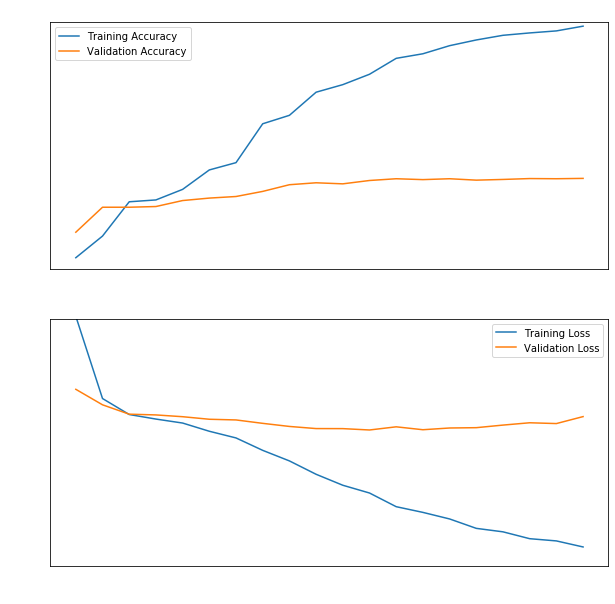

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Cross Entropy')
plt.ylim([0.0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [61]:
test_loss, test_acc = embeddings_model.evaluate(test_dataset_embedding, verbose=3)

print('Loss:', test_loss)
print('Accuracy:', test_acc)

Loss: 0.6390018363793691
Accuracy: 0.70889574


In [62]:
features, labels = next(iter(test_dataset_embedding))

test_index = np.random.randint(features.shape[0])
test_input = features[test_index]
test_label = labels[test_index]
predictions = embeddings_model.predict(tf.expand_dims(test_input, axis=0))

expected_labels = np.array(CLASS_NAMES)[np.argwhere(test_label == 1)].flatten()
predicted_labels = ""
for i in (-predictions[0]).argsort()[:2]:
  predicted_labels += CLASS_NAMES[i] + " (" + str(np.around(predictions[0][i], decimals=2)) + ")\n"

test_input_decoded = " ".join([reverse_word_map[x] for x in test_input.numpy()[test_input.numpy() != 0]])

print('Input',test_input_decoded)
print('Expected labels',expected_labels)
print('\nTop 2 predicted labels are:\n', predicted_labels)

Input history make that high school may itself when learns that the mean girl from her past is set to be her sister in law before the wedding toll must show her brother that tiger doesn change its stripes on side is her mother while backed by her wealthy aunt
Expected labels ['Comedy' 'Romance']

Top 2 predicted labels are:
 Comedy (0.61)
Drama (0.29)



In [63]:
test_input = "The Imperial Forces -- under orders from cruel Darth Vader (David Prowse) -- hold Princess Leia (Carrie Fisher) hostage, in their efforts to quell the rebellion against the Galactic Empire. Luke Skywalker (Mark Hamill) and Han Solo (Harrison Ford), captain of the Millennium Falcon, work together with the companionable droid duo R2-D2 (Kenny Baker) and C-3PO (Anthony Daniels) to rescue the beautiful princess, help the Rebel Alliance, and restore freedom and justice to the Galaxy."
test_input_encoded = pad_sequences(tokenizer.texts_to_sequences([test_input,]), maxlen=max_len, padding='post')
test_input_encoded.shape

(1, 974)

In [64]:
predictions = embeddings_model.predict(test_input_encoded)
predicted_labels = ""
for i in (-predictions[0]).argsort()[:2]:
  predicted_labels += CLASS_NAMES[i] + " (" + str(np.around(predictions[0][i], decimals=2)) + ")\n"

print('\nTop 2 predicted labels are:\n', predicted_labels)


Top 2 predicted labels are:
 Action (0.7)
Thriller (0.43)

